In [1]:
import os
import pickle
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7.5))

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

In [2]:
behavior_path = 'data/behaviors_new_with_kmeans_labels.tsv'
bias_detection_path = 'data/0929_concat_mind_over_res.csv'


In [3]:

# 加载用户候选集
behavior_df = pd.read_csv(behavior_path, sep='\t', header=None)
behavior_df.columns = ['idx', 'uid', 'date', 'history', 'impression', 'labels']


In [4]:
behavior_df.head()

,idx,uid,date,history,impression,labels
0,2,U231077,11/19/2019 5:28:08 AM,N45124 N84730 N45128 N104312 N70022 N99111 N26...,N14657 N51253 N49521 N126571 N74286 N101071 N1...,2
1,4,U320649,11/21/2019 6:03:51 AM,N110863 N7889 N86335 N85056 N115743 N63372 N19...,N119559 N37657 N108085 N91287 N39136 N130190 N...,3
2,7,U593249,11/21/2019 10:26:28 AM,N130269 N110630 N127780 N103724 N88400 N57296 ...,N40488 N69116 N47516,3
3,9,U394469,11/18/2019 9:21:22 AM,N58992 N109724 N79285 N53198 N121550 N28461 N5...,N55737 N31058 N21387 N111735 N78312 N60321 N12...,3
4,14,U44514,11/19/2019 11:45:01 AM,N60061 N124453 N95072 N90578 N80545 N16463 N36...,N2296 N62785 N15647 N16531 N101071 N54103 N646...,4


### Step 3: Filter some browsing records that are too short

In [5]:
def filter_by_length(history, min_len=5):
    if len(history.split()) < min_len:
        return False
    else:
        return True

In [6]:
len_boolean = behavior_df.apply(lambda x: filter_by_length(x['history'], min_len=5), axis=1)

In [7]:
behavior_df = behavior_df[len_boolean]

In [8]:
behavior_df.shape

(279737, 6)

### Step 4: calculate bias proportion for each user

In [9]:
bias_detection_df = pd.read_csv(bias_detection_path, header=None, sep='\t')
bias_detection_df.columns = ['nid', 'category', 'sub_category', 'bias_prob']
bias_detection_df.shape

(122137, 4)

In [10]:
nid2prob = dict(zip(bias_detection_df['nid'], bias_detection_df['bias_prob']))


In [11]:


# uid, num_unbiased, num_biased, num_unknown, unbiased_nid_list, biased_nid_list

def get_user_info(user_group, news_bias_path):
    empty_uids = []
    num_miss_uid = 0
    uid_list = []
    label_list = []
    num_unbiased_list = []
    num_biased_list = []
    num_unknown_list = []
    num_total_list = []
    total_nid_unbiased_list = []
    total_nid_biased_list = []
    total_nid_unknown_list = []
    
    news_bias_df = pd.read_csv(news_bias_path, sep="\t", header=None)
    news_bias_df.columns = ['nid', 'category', 'sub_category', 'bias_prob']
    nid2category = news_bias_df.set_index('nid').to_dict()['category']
    nid2sub_category = news_bias_df.set_index('nid').to_dict()['sub_category']
    nid2bias_prob = news_bias_df.set_index('nid').to_dict()['bias_prob']
    
    for uid, grouped in user_group:
        
        try:
            num_unbiased = 0
            num_biased = 0
            num_unknown = 0
            nid_biased_list = []
            nid_unbiased_list = []
            nid_unknown_list = []
            
            nid_history_list = grouped.iloc[0]["history"].split(" ")
            for nid in nid_history_list:
                if nid in nid2bias_prob:
                    if nid2bias_prob[nid] >= 0.5:
                        num_biased += 1
                        nid_biased_list.append(nid)
                    else:
                        num_unbiased += 1
                        nid_unbiased_list.append(nid)
                else:
                    num_unknown += 1
                    nid_unknown_list.append(nid)
            
            uid_list.append(uid)
            label_list.append(grouped.iloc[0]["labels"])
            num_unbiased_list.append(num_unbiased)
            num_biased_list.append(num_biased)
            num_unknown_list.append(num_unknown)
            num_total_list.append(len(nid_history_list))
            total_nid_unbiased_list.append(nid_unbiased_list)
            total_nid_biased_list.append(nid_biased_list)
            total_nid_unknown_list.append(nid_unknown_list)
        except:
            empty_uids.append(uid)
            num_miss_uid += 1
            
    assert len(empty_uids) == num_miss_uid
    user_info_df = pd.DataFrame(
        {'uid': uid_list,
         'label': label_list,
         'num_unbiased': num_unbiased_list,
         'num_biased': num_biased_list,
         'num_unknown': num_unknown_list,
         'num_total': num_total_list,
         'total_nid_unbiased': total_nid_unbiased_list,
         'total_nid_biased': total_nid_biased_list,
         'total_nid_unknown': total_nid_unknown_list,
        }
    )
    
    return user_info_df, empty_uids



In [12]:
user_group = behavior_df.groupby('uid')

In [13]:
user_info_df, empty_uids = get_user_info(user_group=user_group, 
                                         news_bias_path=bias_detection_path)

In [14]:
user_info_df.head()

,uid,label,num_unbiased,num_biased,num_unknown,num_total,total_nid_unbiased,total_nid_biased,total_nid_unknown
0,U1000,3,9,2,0,11,"[N20131, N65823, N65823, N111503, N3992, N1047...","[N33446, N70022]",[]
1,U100008,4,8,1,0,9,"[N85167, N124096, N72980, N6120, N14320, N1196...",[N46329],[]
2,U100016,4,8,4,0,12,"[N80883, N124796, N89166, N99279, N107732, N70...","[N20915, N79214, N29936, N29044]",[]
3,U100019,0,16,1,0,17,"[N55903, N98238, N109468, N29748, N123353, N73...",[N126000],[]
4,U100020,4,5,0,0,5,"[N119718, N126611, N127629, N3664, N93856]",[],[]


In [15]:
user_info_df['bias_prop'] = user_info_df['num_biased'] / user_info_df['num_total']

In [16]:
user_info_df.head()

,uid,label,num_unbiased,num_biased,num_unknown,num_total,total_nid_unbiased,total_nid_biased,total_nid_unknown,bias_prop
0,U1000,3,9,2,0,11,"[N20131, N65823, N65823, N111503, N3992, N1047...","[N33446, N70022]",[],0.181818
1,U100008,4,8,1,0,9,"[N85167, N124096, N72980, N6120, N14320, N1196...",[N46329],[],0.111111
2,U100016,4,8,4,0,12,"[N80883, N124796, N89166, N99279, N107732, N70...","[N20915, N79214, N29936, N29044]",[],0.333333
3,U100019,0,16,1,0,17,"[N55903, N98238, N109468, N29748, N123353, N73...",[N126000],[],0.058824
4,U100020,4,5,0,0,5,"[N119718, N126611, N127629, N3664, N93856]",[],[],0.000000


In [17]:
user_info_df.shape

(279737, 10)

In [18]:

user_df_0 = user_info_df[user_info_df['label'] == 0]
user_df_0.shape

(26956, 10)

In [19]:
user_df_0['bias_prop'].mean()

0.17138035201175789

In [20]:

user_df_1 = user_info_df[user_info_df['label'] == 1]
user_df_1.shape


(31926, 10)

In [21]:
user_df_1['bias_prop'].mean()

0.08808627629510966

In [22]:

user_df_2 = user_info_df[user_info_df['label'] == 2]
user_df_2.shape


(26657, 10)

In [23]:
user_df_2['bias_prop'].mean()

0.11331830679450383

In [24]:

user_df_3 = user_info_df[user_info_df['label'] == 3]
user_df_3.shape


(125154, 10)

In [25]:
user_df_3['bias_prop'].mean()

0.11492564781471797

In [26]:

user_df_4 = user_info_df[user_info_df['label'] == 4]
user_df_4.shape


(69044, 10)

In [27]:
user_df_4['bias_prop'].mean()

0.14144675058899484

In [28]:

interest_intervals = {
    'Interest 1': 26956,
    'Interest 2': 31926,
    'Interest 3': 26657,
    'Interest 4': 125154,
    'Interest 5': 69044,
}





In [29]:

user_df_0['bias_prop'].mean(), user_df_1['bias_prop'].mean(), user_df_2['bias_prop'].mean(), user_df_3['bias_prop'].mean(), user_df_4['bias_prop'].mean(), 




(0.17138035201175789,
 0.08808627629510966,
 0.11331830679450383,
 0.11492564781471797,
 0.14144675058899484)

<AxesSubplot:ylabel='Frequency'>

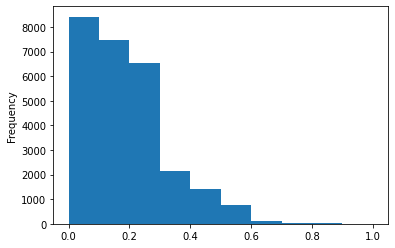

In [30]:

user_df_0['bias_prop'].plot.hist()



<AxesSubplot:ylabel='Frequency'>

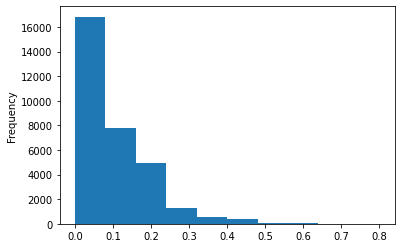

In [31]:

user_df_1['bias_prop'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

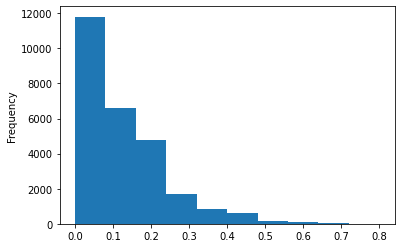

In [32]:

user_df_2['bias_prop'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

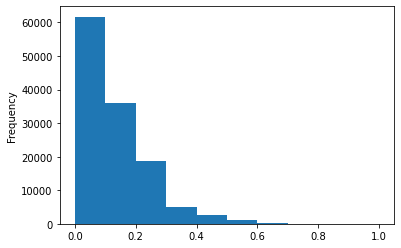

In [33]:

user_df_3['bias_prop'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

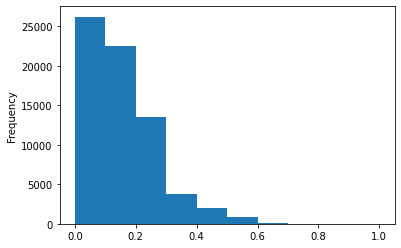

In [34]:

user_df_4['bias_prop'].plot.hist()


In [30]:


def cal_groups(idx, user_df_tmp, num_sample=2000):
    
    print(idx, user_df_tmp.bias_prop.quantile(), f'medium is: {user_df_tmp.bias_prop.quantile():.2f}')
    media_split_col = user_df_tmp.bias_prop<user_df_tmp.bias_prop.quantile()  # medium split 
    low_user_df = user_df_tmp[media_split_col]
    high_user_df = user_df_tmp[~media_split_col]
        
    low_bias_prop = low_user_df['bias_prop'].tolist()
    high_bias_prop = high_user_df['bias_prop'].tolist()
    
    print(f'group {idx} mw test', mannwhitneyu(low_bias_prop, high_bias_prop, alternative='two-sided'))

    user_info_low = low_user_df.sample(n=num_sample, random_state=2022)
    user_info_high = high_user_df.sample(n=num_sample, random_state=2022)
    
    print(f'group {idx} mean ori:', f'{user_df_tmp["bias_prop"].mean()}', f'{low_user_df["bias_prop"].mean()}', f'{high_user_df["bias_prop"].mean()}')
    print(f'group {idx} mean:', f'{user_df_tmp["bias_prop"].mean()*100:.2f}', f'{low_user_df["bias_prop"].mean()*100:.2f}', f'{high_user_df["bias_prop"].mean()*100:.2f}')
    print(f'group {idx} sample mean ori:', f'{user_info_low["bias_prop"].mean()}', f'{user_info_high["bias_prop"].mean()}')
    print(f'group {idx} sample mean:', f'{user_info_low["bias_prop"].mean()*100:.2f}', f'{user_info_high["bias_prop"].mean()*100:.2f}')
    
    return user_info_low, user_info_high
    

In [32]:
# draw plots


label_list = sorted(user_info_df['label'].unique().tolist())
color_list = ['salmon', 'khaki', 'lightskyblue', 'lavender', 'orchid']

for j, l in enumerate(label_list):
    user_df_tmp = user_info_df[user_info_df['label'] == l]
    plt.hist([i*100 for i in user_df_tmp.bias_prop.tolist()], color=color_list[j])
    plt.axvline(user_df_tmp.bias_prop.quantile()*100, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel(f'Bias Proportion', fontweight='bold', fontsize=12)
    plt.ylabel('The Number of Users', fontweight='bold', fontsize=12)
    plt.xlim((0, 100))
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
#     plt.show()
    plt.savefig(f'pdf/stat_data_interest_hist_l{l}.pdf', bbox_inches='tight')
    plt.close()



In [37]:
# print(f'{0.16666666666666666*100:.2f}', f'{0.07142857142857142*100:.2f}',
#       f'{0.1*100:.2f}', f'{0.1*100:.2f}',
#       f'{0.125*100:.2f}')

In [38]:

num_sample=2000
label_list = sorted(user_info_df['label'].unique().tolist())
user_info_dict = dict()

for l in label_list:
    
    user_df_tmp = user_info_df[user_info_df['label'] == l]
    user_info_low, user_info_high = cal_groups(l, user_df_tmp, num_sample=num_sample)
    
    user_info_dict[f'{l}_interests_low'] = user_info_low
    user_info_dict[f'{l}_interests_high'] = user_info_high
    

0 0.16666666666666666 medium is: 0.17
group 0 mw test MannwhitneyuResult(statistic=0.0, pvalue=0.0)
group 0 mean ori: 0.17138035201175789 0.057511567158988315 0.28128112059568455
group 0 mean: 17.14 5.75 28.13
group 0 sample mean ori: 0.05740202198568943 0.276845280948735
group 0 sample mean: 5.74 27.68
1 0.07142857142857142 medium is: 0.07
group 1 mw test MannwhitneyuResult(statistic=0.0, pvalue=0.0)
group 1 mean ori: 0.08808627629510966 0.007794210012763122 0.167667261536415
group 1 mean: 8.81 0.78 16.77
group 1 sample mean ori: 0.008007450013983794 0.16689902529150072
group 1 sample mean: 0.80 16.69
2 0.1 medium is: 0.10
group 2 mw test MannwhitneyuResult(statistic=0.0, pvalue=0.0)
group 2 mean ori: 0.11331830679450383 0.02117357852706133 0.2040157715764346
group 2 mean: 11.33 2.12 20.40
group 2 sample mean ori: 0.022257271487105455 0.20572067208157496
group 2 sample mean: 2.23 20.57
3 0.1 medium is: 0.10
group 3 mw test MannwhitneyuResult(statistic=0.0, pvalue=0.0)
group 3 mean ori

In [39]:
# check
user_info_dict.keys()

dict_keys(['0_interests_low', '0_interests_high', '1_interests_low', '1_interests_high', '2_interests_low', '2_interests_high', '3_interests_low', '3_interests_high', '4_interests_low', '4_interests_high'])

In [40]:

for k in user_info_dict.keys():
    print(k, user_info_dict[k]['bias_prop'].mean())


0_interests_low 0.05740202198568943
0_interests_high 0.276845280948735
1_interests_low 0.008007450013983794
1_interests_high 0.16689902529150072
2_interests_low 0.022257271487105455
2_interests_high 0.20572067208157496
3_interests_low 0.023889702968626865
3_interests_high 0.20445112962854245
4_interests_low 0.04306683470765054
4_interests_high 0.2269189007511229


In [41]:
with open(f'data/interests_user_info_dict_{num_sample}.pkl', "wb") as f:
    pickle.dump(user_info_dict, f)